
Bad key text.latex.unicode in file /Users/madhavprasad/mlexercise/jupyter-env/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key text.latex.preview in file /Users/madhavprasad/mlexercise/jupyter-env/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 125 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/madhavprasad/mlexercise/jupyter-env/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 157 ('mathtext.fal

1/1 [==============================] - 0s 10ms/step


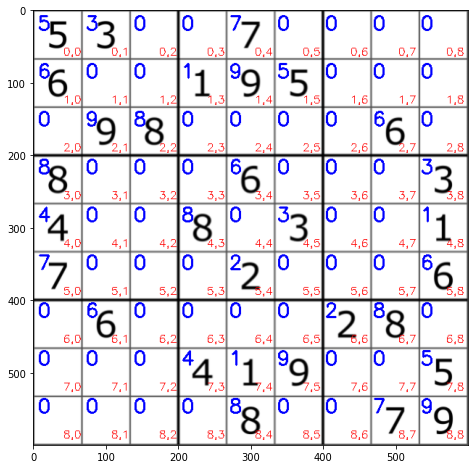

Are all numbers predicted correctly? (y/n)y
SOLVED!!!


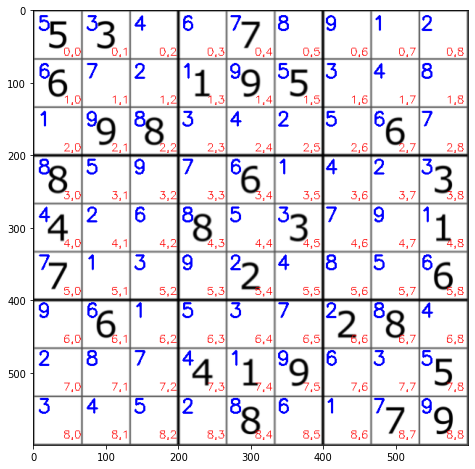

'\ncv2.imshow(\'solved\',x)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\nprint("a")\n'

In [1]:
import cv2
import imutils
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
from tensorflow.keras.models import load_model
import numpy as np
#from Sudoku import solveSudoku
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt


model = load_model('model/')
img_path = 'sudoku images/6.png'
img_shape = [28,28]

def solveSudoku(board):
    for i in range(9):
        for j in range(9):
            if board[i][j]!='.':
                board[i][j] = int(board[i][j])
            else:
                board[i][j] = 0
                
    def return_empty(board):
        for i in range(9):
            for j in range(9):
                if board[i][j]==0:
                    return(i,j)
        return None
    
    def check(board,num,pos):
        row,col = pos
    
        # checking row
        for i in range(9):
            if board[row][i]==num and i!=col:
                return False
    
        # checking col
        for i in range(9):
            if board[i][col]==num and i!=row:
                return False
    
        # checking for sub-grid
        box_x = row//3
        box_y = col//3
    
        for i in range(box_x*3,box_x*3+3):
            for j in range(box_y*3,box_y*3+3):
                if board[i][j]==num and (i,j)!=pos:
                    return False
        return True
    
    def solve(board):
        vacant = return_empty(board)
        if vacant is None:return True #means all cells are filled now and we have completed the sudoku
        row,col = vacant
        for i in range(1,10):
            if check(board,i,vacant):
                board[row][col] = i
                if solve(board):
                    return True
                board[row][col] = 0
        return False
    
    solve(board)
    
    return board

'''board = [[8, 0, 0, 0, 1, 0, 0, 0, 9],
        [0, 5, 0, 8, 0, 7, 0, 1, 0],
        [0, 0, 4, 0, 9, 0, 7, 0, 0],
        [0, 6, 0, 7, 0, 1, 0, 2, 0],
        [5, 0, 8, 0, 6, 0, 1, 0, 7],
        [0, 1, 0, 5, 0, 2, 0, 9, 0],
        [0, 0, 7, 0, 4, 0, 6, 0, 0],
        [0, 8, 0, 3, 0, 9, 0, 4, 0],
        [3, 0, 0, 0, 5, 0, 0, 0, 8]]

print(solveSudoku(board))'''
def find_puzzle(img):
    real = img.copy()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),1)
    
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    thresh = cv2.bitwise_not(thresh)

    cnts = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts,key=cv2.contourArea,reverse=True)

    puzzle_cnt = None

    for c in cnts:
        peri = cv2.arcLength(c,True)
        approx = cv2.approxPolyDP(c,0.02*peri,True)
        if len(approx)==4:
            puzzle_cnt=approx
            break

    if puzzle_cnt is None:
        raise Exception(("Could not find Sudoku puzzle outline.Try debugging your thresholding and contour steps."))        

    cv2.drawContours(real, [puzzle_cnt], -1, (0, 255, 0), 2)

    puzzle = four_point_transform(img, puzzle_cnt.reshape(4, 2))
    warped = four_point_transform(gray, puzzle_cnt.reshape(4, 2))

    return puzzle,warped



def extract_digit(cell):
    thresh = cv2.threshold(cell,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    thresh = clear_border(thresh) #just clear the extra white pixels along the border


    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # if no contours were found then this is an empty cell
    if len(cnts) == 0:return None

    # otherwise, find the largest contour in the cell and create a mask for the contour
    c = max(cnts, key=cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)

    (h, w) = thresh.shape
    percentFilled = cv2.countNonZero(mask) / float(w * h)

    # if less than 3% of the mask is filled then we are looking at noise and can safely ignore the contour
    if percentFilled < 0.03:return None

    # apply the mask to the thresholded cell
    digit = cv2.bitwise_and(thresh, thresh, mask=mask)
    kernel = np.ones((1,1),np.uint8)
    digit = cv2.dilate(digit,kernel,iterations=1)

    # return the digit to the calling function
    return digit


def display_numbers_on_board(board,puzzle):
    x = puzzle.copy()
    k = 0
    for i in range(9):
        for j in range(9):
            startX,startY,endX,endY = cell_locs[k]
            testX = int((endX - startX) * 0.1)
            testY = int((endY - startY) * -0.6)
            testX += startX
            testY += endY
            cv2.putText(x,str(board[i][j]),(testX,testY),cv2.FONT_HERSHEY_SIMPLEX,0.9,(0,0,255),2)
            cv2.putText(x,(str(i)+','+str(j)),(testX+35,testY+35),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),1)
            
            k+=1
    
    plt.figure(figsize=(12,8))
    plt.imshow(x)
    plt.show()
    return x

img = cv2.imread('img5.png')
img = imutils.resize(img,width=600)

puzzle,warped = find_puzzle(img)
puzzle = imutils.resize(puzzle,width=600)
warped = imutils.resize(warped,width=600)

step_x = warped.shape[1]//9
step_y = warped.shape[0]//9

board = np.zeros(shape=(9,9),dtype='int')
cell_locs = []

for i in range(9):
    for j in range(9):
        topleftx = j*step_x
        toplefty = i*step_y
        rightendx= (j+1)*step_x
        rightendy = (i+1)*step_y
        cell = warped[toplefty:rightendy, topleftx:rightendx]
        digit = extract_digit(cell)
        if digit is not None:
            roi = cv2.resize(digit,tuple(img_shape))
            roi = roi.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)
            pred = model.predict(roi).argmax(axis=1)[0]
            board[i,j] = pred
        cell_locs.append([topleftx,toplefty,rightendx,rightendy])

        
x = display_numbers_on_board(board,puzzle)

while 1:
    res = input('Are all numbers predicted correctly? (y/n)')
    if res=='n':
        cx,cy,ele = input('Input row no, col no, correct element of cell For eg. --> 1 2 1:  ').split()
        try:
            board[int(cx),int(cy)] = int(ele)
        except:
            print('out of range...')
        display_numbers_on_board(board,puzzle)
    elif res=='y':
        print('SOLVED!!!')
        break
    else:
        print('Wrong choice!!!')
solved = solveSudoku(board)
#print(solveSudoku(board))
x = display_numbers_on_board(solved,puzzle)
'''
cv2.imshow('solved',x)
cv2.waitKey(0)
cv2.destroyAllWindows()
print("a")
'''

Note: you may need to restart the kernel to use updated packages.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
Note: you may need to restart the kernel to use updated packages.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 3.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
